In [1]:
import os
import math
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import image as mpimg

import seaborn as sns

from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

from PIL import Image

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms

from collections import Counter

from imblearn.over_sampling import RandomOverSampler

import pickle

# Uvod i učitavanje podataka

U ovom projektu korišćen je Artemis dataset, koji sadrži umetničke slike i emocije koje su im pridružene. Prvi korak je učitavanje podataka iz CSV fajla, a takođe je postavljen uređaj (GPU ili CPU) koji se koristi za ubrzanje treniranja modela.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
data = pd.read_csv('kaggle/input/artemis-full/artemis.csv')

In [4]:
data.head()

Unnamed: 0           art_style  \
0           0  Post_Impressionism   
1           1  Post_Impressionism   
2           2  Post_Impressionism   
3           3  Post_Impressionism   
4           4  Post_Impressionism   

                                            painting         emotion  \
0  vincent-van-gogh_portrait-of-madame-ginoux-l-a...  something else   
1  vincent-van-gogh_portrait-of-madame-ginoux-l-a...         sadness   
2  vincent-van-gogh_portrait-of-madame-ginoux-l-a...  something else   
3  vincent-van-gogh_portrait-of-madame-ginoux-l-a...     contentment   
4  vincent-van-gogh_portrait-of-madame-ginoux-l-a...             awe   

                                           utterance  repetition  \
0  She seems very happy in the picture, and you w...          10   
1  This woman has really knotty hands which makes...          10   
2  When looking at this woman, I am filled with c...          10   
3  A woman looking at ease, peaceful, and satisfi...          10   
4  She looks like a lady from that past that migh...          10   

                                                path  
0  /kaggle/input/wikiart/Post_Impressionism/vince...  
1  /kaggle/input/wikiart/Post_Impressionism/vince...  
2  /kaggle/input/wikiart/Post_Impressionism/vince...  
3  /kaggle/input/wikiart/Post_Impressionism/vince...  
4  /kaggle/input/wikiart/Post_Impressionism/vince...

In [5]:
print(f"Oblik dataset-a: {data.shape}")

Oblik dataset-a: (450555, 7)


# Ažuriranje putanja slika
Pošto putanje slika u dataset-u mogu biti drugačije na lokalnoj mašini, prilagođene su putanje lokalnom sistemu.

In [6]:
correct_path_prefix = 'kaggle/input/wikiart/'
def update_path(path):
    return path.replace('/kaggle/input/wikiart/', correct_path_prefix)

data['path'] = data['path'].apply(update_path)

# Stratifikovano uzorkovanje podataka
Kako bi se izbegla nebalansiranost podataka, uzorkovani su podaci tako da svaka klasa (emocija) bude jednako zastupljena. Ovaj korak uzima po 300 instanci za svaku emociju.

In [7]:
samples_per_class = 300

# Grupisanje podataka po emocijama i uzimanje po 300 uzoraka za svaku klasu
grouped_data = data.groupby('emotion', group_keys=False).apply(lambda x: x.sample(min(len(x), samples_per_class), random_state=42))

# Provera veličine uzorka
print(f"Ukupan broj zapisa nakon stratifikovanog uzorkovanja: {grouped_data.shape}")
data = grouped_data

Ukupan broj zapisa nakon stratifikovanog uzorkovanja: (2700, 7)


In [8]:
data.shape

(2700, 7)

# Prikaz slika sa emocijama

In [9]:
def plot_images_with_emotions_grid(df, num_images=10, columns=5):
    rows = math.ceil(num_images / columns) 
    fig, axes = plt.subplots(rows, columns, figsize=(20, 4 * rows)) 
    axes = axes.flatten()
    
    for i, (index, row) in enumerate(df.iterrows()):
        if i >= num_images:
            break
        try:
            img = mpimg.imread(row['path'])
            axes[i].imshow(img)
            axes[i].set_title(f"Emocija: {row['emotion']}")
            axes[i].axis('off')
        except FileNotFoundError:
            print(f"Slika nije pronađena na putanji {row['path']}")
            axes[i].axis('off')
    
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

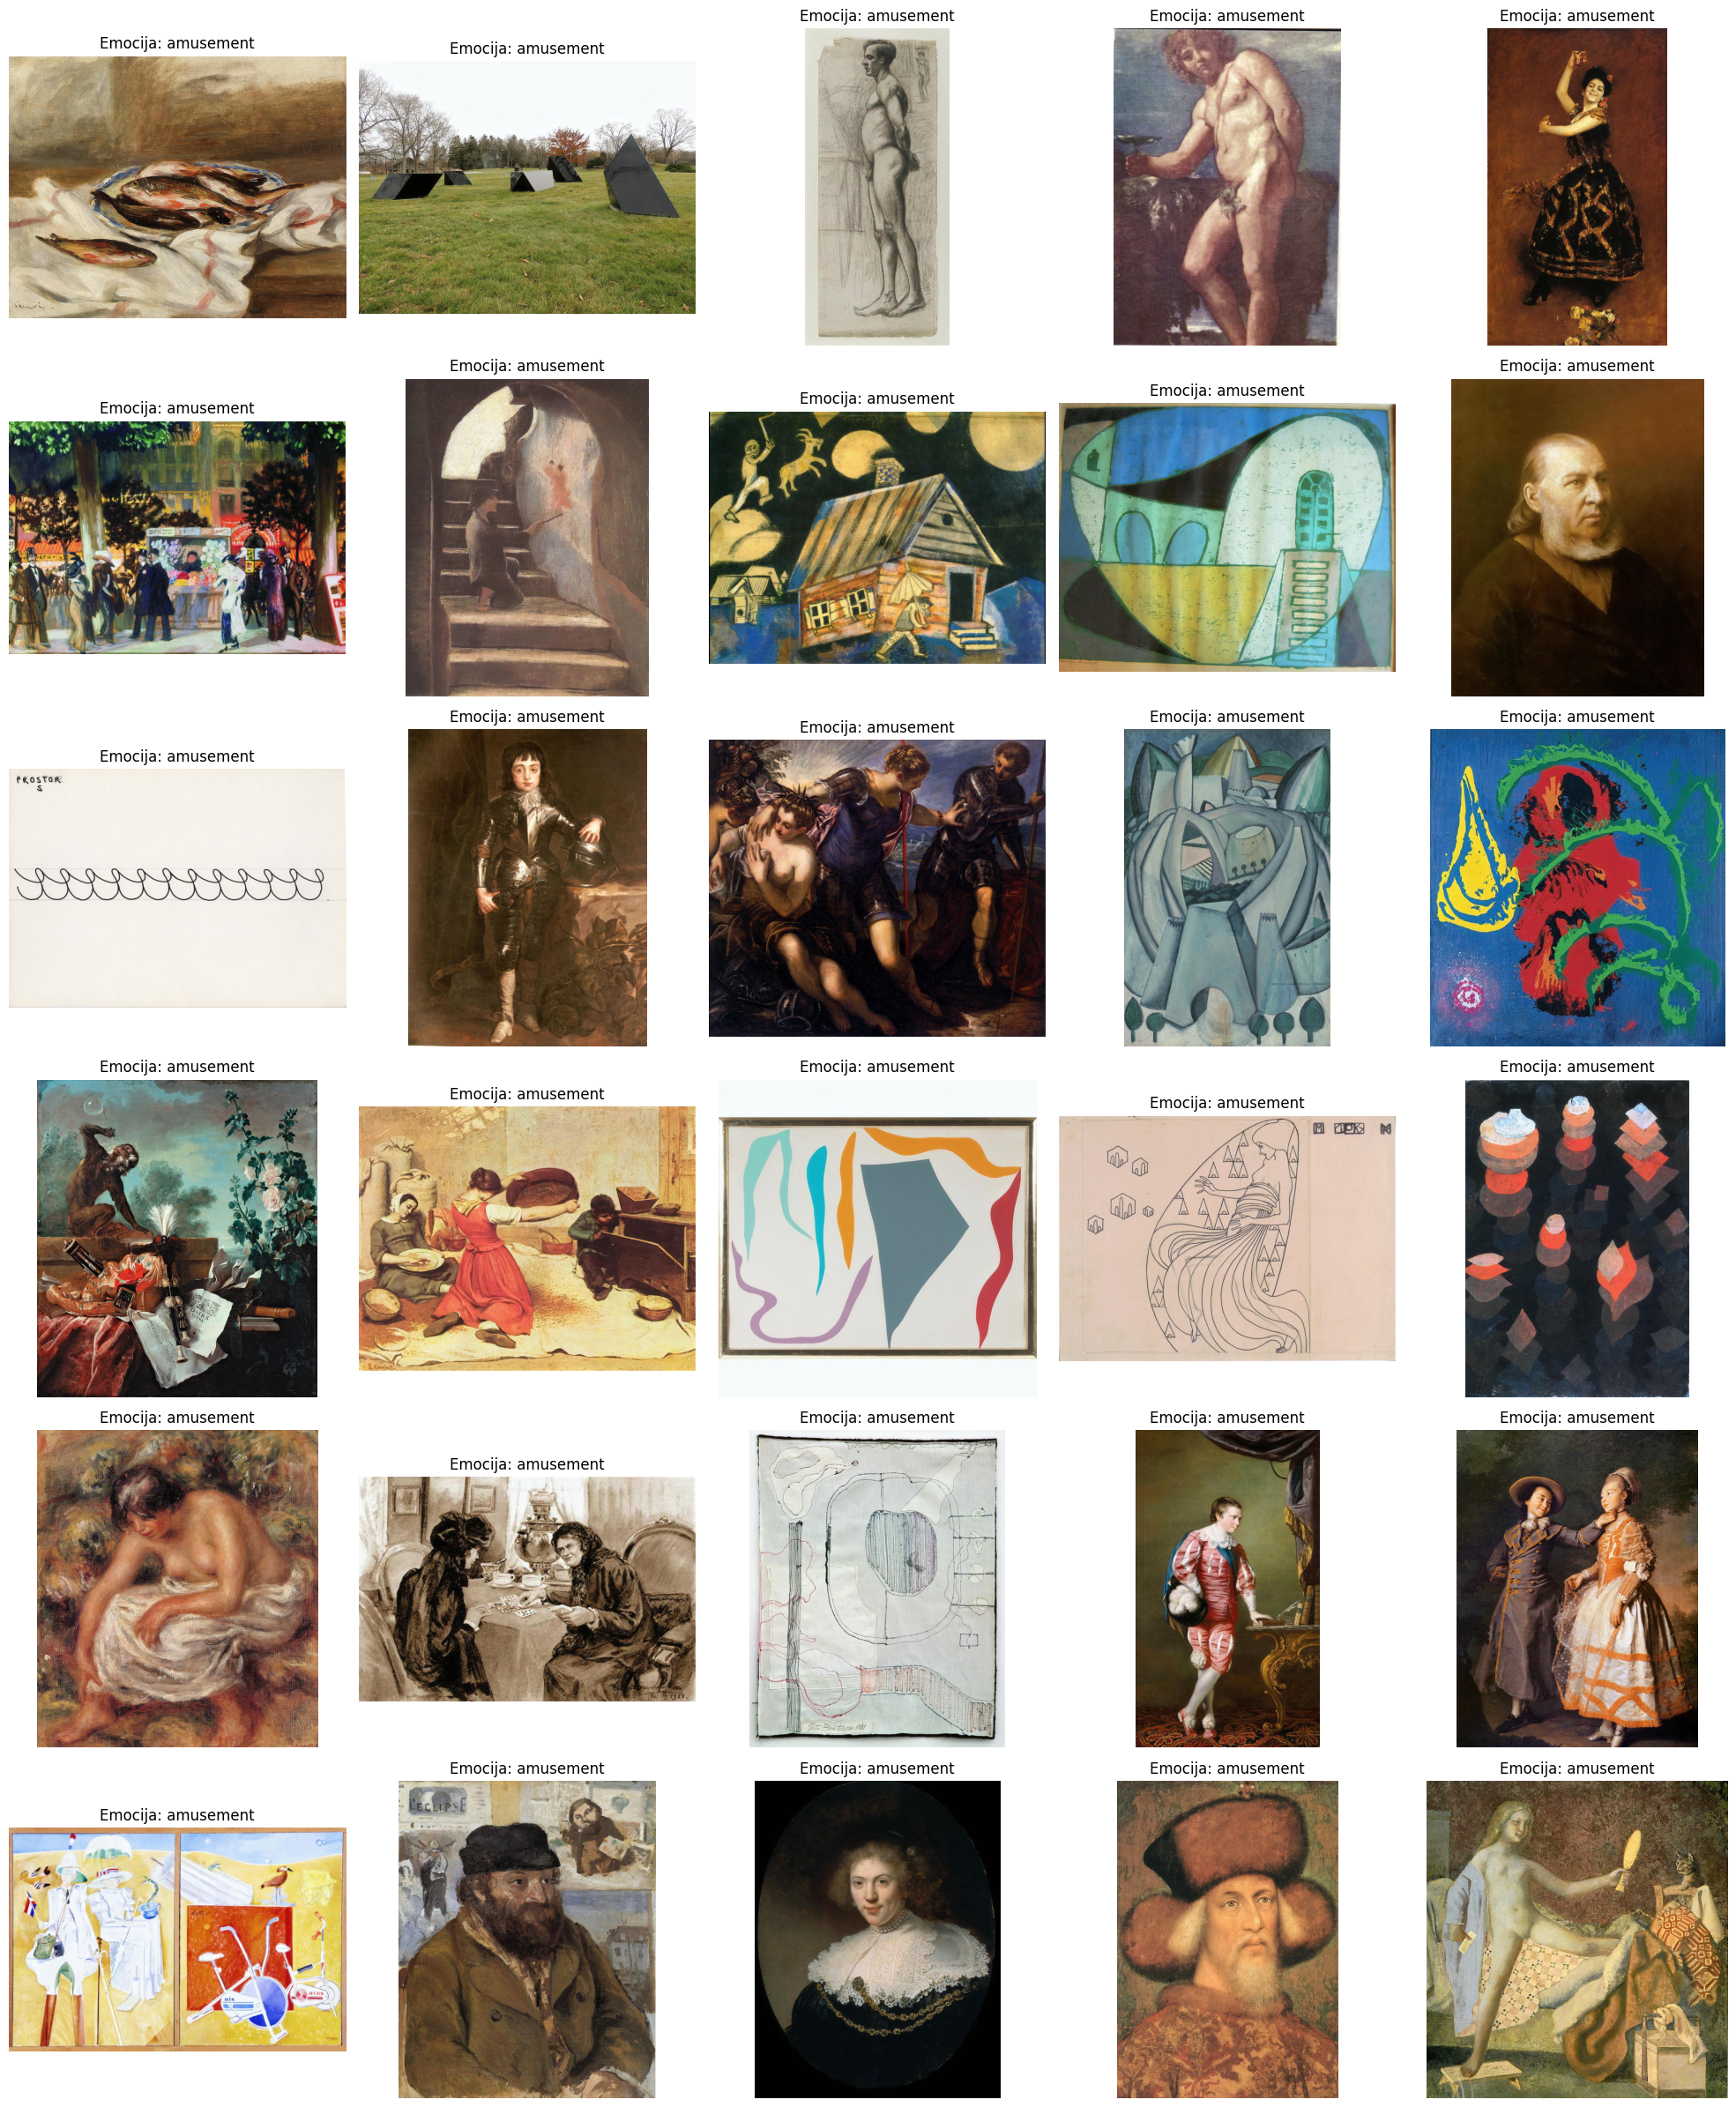

In [10]:
plot_images_with_emotions_grid(data, num_images=30)

# Vizualizacija distribucije emocija

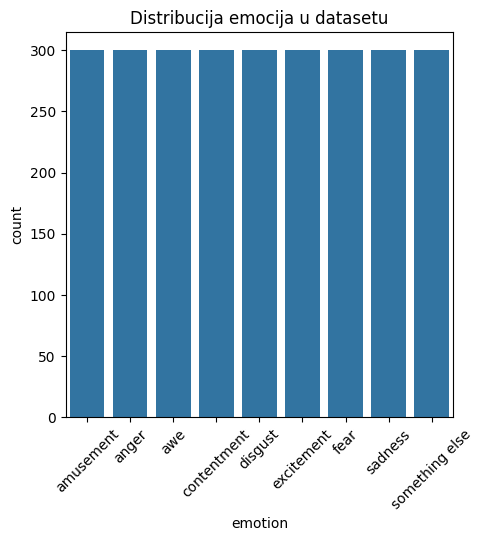

In [11]:
plt.figure(figsize=(5,5))
sns.countplot(x='emotion', data=data, order=data['emotion'].value_counts().index)
plt.title('Distribucija emocija u datasetu')
plt.xticks(rotation=45)
plt.show()

# Grupisanje emocija po slikama
Pošto jedna slika može imati više emocija, grupisane su emocije za svaku sliku.

In [12]:

data = data.sort_values(by='path')
data_grouped = data.groupby('path')['emotion'].apply(list).reset_index()
data = data_grouped
image_paths = data['path'].values
emotions = data['emotion'].values

print(f"Broj slika: {len(image_paths)}, Broj emocionalnih zapisa: {len(emotions)}")


Broj slika: 2638, Broj emocionalnih zapisa: 2638


# Pretvaranje emocija u binarne vrednosti (OneHotEncoder)
Da bi model mogao raditi sa višelabelnim ciljnim promenljivama, emocije su pretvorene u binarne vektore koristeći MultiLabelBinarizer. Svaka emocija je predstavljena kao binarna vrednost (0 ili 1) u vektoru.

MultiLabelBinarizer konvertuje liste emocija u binarne vektore.

fit_transform(emotions) primenjuje enkodiranje na sve emocije i pretvara ih u binarne oznake.

In [13]:
onehot_encoder = preprocessing.MultiLabelBinarizer()
emotions_encoded = onehot_encoder.fit_transform(emotions)

print("Prvih nekoliko zapisa emocija nakon enkodiranja:")
print(emotions_encoded[:5])


Prvih nekoliko zapisa emocija nakon enkodiranja:
[[0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]]


# Podela podataka na train, validation i test setove
Podaci su podeljeni na train (za treniranje modela), validation (za proveru performansi modela tokom treniranja) i test (za završnu evaluaciju modela).

In [14]:
image_paths_train, image_paths_temp, y_train, y_temp = model_selection.train_test_split(
    image_paths, emotions_encoded, test_size=0.4, random_state=7
)
image_paths_val, image_paths_test, y_val, y_test = model_selection.train_test_split(
    image_paths_temp, y_temp, test_size=0.5, random_state=7
)

# Transformacije slika
Za poboljšanje generalizacije modela, primenjuju se transformacije slika, kao što su promena veličine, rotacija i horizontalna rotacija. Ove transformacije pomažu modelu da bolje nauči varijacije u podacima.


Resize menja veličinu slike na 224x224 piksela, što je uobičajena veličina za CNN modele poput ResNet-a i AlexNet-a..


RandomHorizontalFlip rotira slike horizontalno.


RandomRotation rotira slike nasumično do 10 stepeni.


ToTensor konvertuje slike u tenzore za PyTorch.


Normalize normalizuje vrednosti piksela koristeći standardne vrednosti za ImageNet modele.

In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Kreiranje PyTorch dataset-a
PyTorch zahteva kreiranje specifične klase za dataset koja učitava slike i njihove oznake. Dataset omogućava modelu da učitava slike tokom treniranja i validacije.

In [16]:
class ArtDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths 
        self.labels = labels  # Binarni vektori emocija (višelabelske oznake)
        self.transform = transform  # Transformacije za slike
    
    def __len__(self):
        return len(self.image_paths)  # Broj slika
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Učitavanje slike
        
        if self.transform:
            image = self.transform(image)  # Primena transformacija (npr. normalizacija)
        
        label = self.labels[idx]  # Binarni vektor emocija (etikete)
        return image, label  # Vraća sliku i pripadajuće oznake

# Kreiranje Dataset-a za treniranje, validaciju i testiranje i DataLoader-a

In [17]:

train_dataset = ArtDataset(image_paths_train, y_train, transform=transform)
val_dataset = ArtDataset(image_paths_val, y_val, transform=transform)
test_dataset = ArtDataset(image_paths_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [18]:
# Provera da li su podaci pravilno podeljeni
print(f"Broj slika u train skupu: {len(train_loader.dataset)}")
print(f"Broj slika u validation skupu: {len(val_loader.dataset)}")
print(f"Broj slika u test skupu: {len(test_loader.dataset)}")


Broj slika u train skupu: 1582
Broj slika u validation skupu: 528
Broj slika u test skupu: 528


# Definisanje modela (ResNet)
Za treniranje modela korišćen je unapred trenirani ResNet-18 model, koji je modifikovan tako da izlazni sloj odgovara broju klasa (emocija) u dataset-u.

In [19]:
class MultiLabelResNet(nn.Module):
    def __init__(self, num_classes):
        super(MultiLabelResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)  # Koristimo ResNet-18
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)  # Prilagođavamo izlazni sloj

    def forward(self, x):
        return self.resnet(x)
        

# Inicijalizacija modela sa brojem klasa

In [20]:
num_classes = emotions_encoded.shape[1]
modelResNet = MultiLabelResNet(num_classes).to(device)

/home/aleksandra/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aleksandra/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Definisanje kriterijuma za gubitak i optimizatora
Za treniranje modela koristi se BCEWithLogitsLoss koji je pogodan za višeklasnu klasifikaciju.
Optimizator koji se koristi je Adam.

In [21]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(modelResNet.parameters(), lr=0.0001, weight_decay=1e-5)

# Funkcija za treniranje modela
Definisana je funkcija za treniranje modela na treniranju i validaciji. Model se trenira kroz više epoha, prateći gubitak (loss) i tačnost (accuracy) tokom svakog prolaza kroz podatke.

In [22]:
def train_classification(model, criterion, optimizer, number_of_epochs, train_loader, validation_loader):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(number_of_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())  # BCEWithLogitsLoss očekuje float
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            predicted = (outputs > 0.5).float()  
            correct += (predicted == labels).sum().item()
            total += labels.numel()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_accuracy = correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)
        print(f"Epoch [{epoch + 1}/{number_of_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}")

        if validation_loader:
            model.eval()
            val_running_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for val_inputs, val_labels in validation_loader:
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                    val_outputs = model(val_inputs)
                    val_loss = criterion(val_outputs, val_labels.float())
                    val_running_loss += val_loss.item()

                    val_predicted = (val_outputs > 0.5).float() 
                    val_correct += (val_predicted == val_labels).sum().item()
                    val_total += val_labels.numel()

            epoch_val_loss = val_running_loss / len(validation_loader)
            epoch_val_accuracy = val_correct / val_total
            val_losses.append(epoch_val_loss)
            val_accuracies.append(epoch_val_accuracy)
            print(f"Epoch [{epoch + 1}/{number_of_epochs}], Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies


# Treniranje ResNet modela

In [23]:
train_losses, train_accuracies, val_losses, val_accuracies = train_classification(
    modelResNet, criterion, optimizer, number_of_epochs=10, 
    train_loader=train_loader, validation_loader=val_loader
) 

Epoch [1/10], Train Loss: 0.4917, Train Accuracy: 0.8519
Epoch [1/10], Validation Loss: 0.3731, Validation Accuracy: 0.8864
Epoch [2/10], Train Loss: 0.3206, Train Accuracy: 0.8870
Epoch [2/10], Validation Loss: 0.3535, Validation Accuracy: 0.8866
Epoch [3/10], Train Loss: 0.2797, Train Accuracy: 0.8887
Epoch [3/10], Validation Loss: 0.3593, Validation Accuracy: 0.8866
Epoch [4/10], Train Loss: 0.2383, Train Accuracy: 0.8946
Epoch [4/10], Validation Loss: 0.3704, Validation Accuracy: 0.8847
Epoch [5/10], Train Loss: 0.1894, Train Accuracy: 0.9145
Epoch [5/10], Validation Loss: 0.3886, Validation Accuracy: 0.8828
Epoch [6/10], Train Loss: 0.1479, Train Accuracy: 0.9353
Epoch [6/10], Validation Loss: 0.4121, Validation Accuracy: 0.8765
Epoch [7/10], Train Loss: 0.1064, Train Accuracy: 0.9593
Epoch [7/10], Validation Loss: 0.4268, Validation Accuracy: 0.8784
Epoch [8/10], Train Loss: 0.0784, Train Accuracy: 0.9749
Epoch [8/10], Validation Loss: 0.4434, Validation Accuracy: 0.8729
Epoch [9

# Prikazivanje rezultata treniranja

In [24]:
def plot_classification(train_loss, train_accuracy, val_loss, val_accuracy):
    number_of_epochs = len(train_loss)
    epochs = range(1, number_of_epochs + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(epochs, train_loss, label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, label='Validation Loss')

    plt.legend()

    # Plotting Training Accuracy
    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(epochs, train_accuracy, label='Training Accuracy')
    if val_accuracy:
        plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

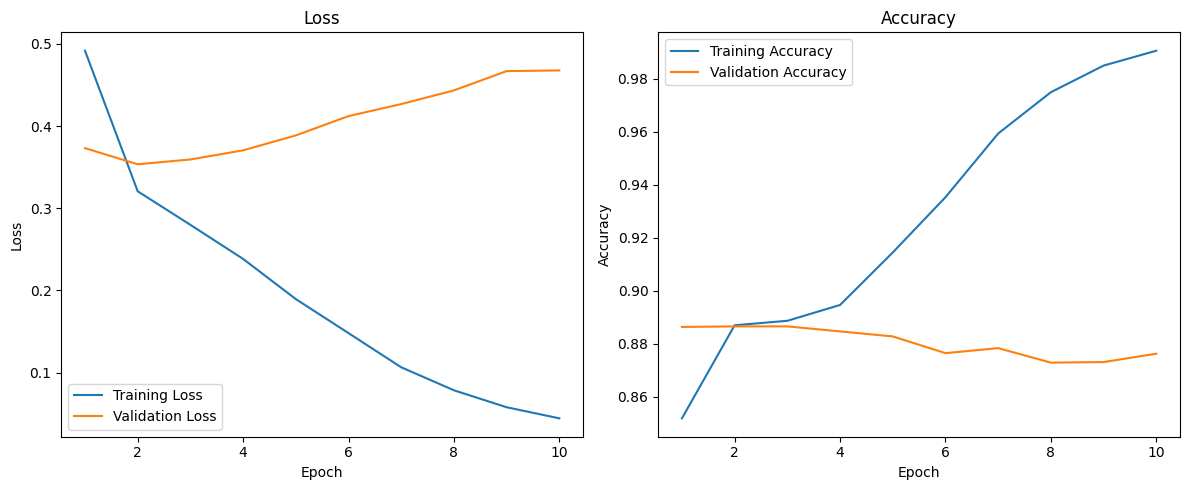

In [25]:
plot_classification(train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluacija modela

In [26]:
def evaluate_classification(model, criterion, loader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    predicted_labels, true_labels = [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
           
            total_loss += criterion(outputs, labels.float()).item()  

         
            predicted = (outputs > 0.5).float()

          
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy()) 

      
            total_samples += labels.numel()
            total_correct += (predicted == labels).sum().item()

 
    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')


    print(f'Model evaluation on: {loader}')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")


    cm = multilabel_confusion_matrix(true_labels, predicted_labels)
    for idx, (conf_matrix, emotion) in enumerate(zip(cm, onehot_encoder.classes_)):
        plt.figure(figsize=(5, 4))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for Emotion: {emotion}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()


    avg_loss = total_loss / len(loader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


# Evaluacija treniranog ResNet modela na test setu

Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x7f0e361c0ee0>
Accuracy: 0.0455
Precision: 0.2509
Recall: 0.0436
F1 Score: 0.0726


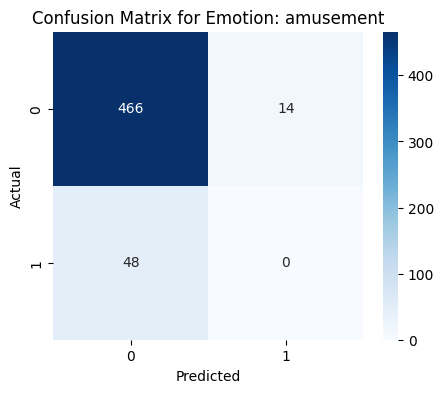

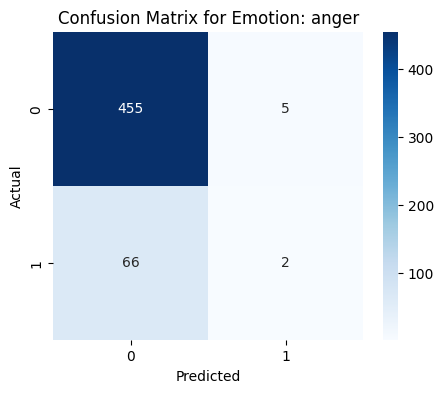

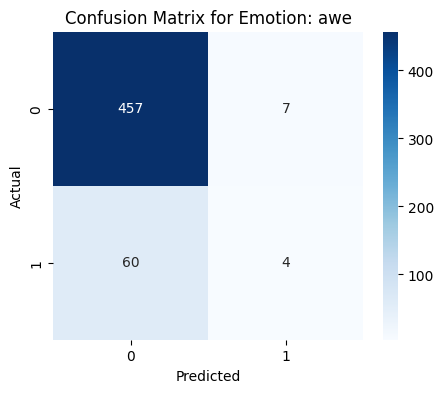

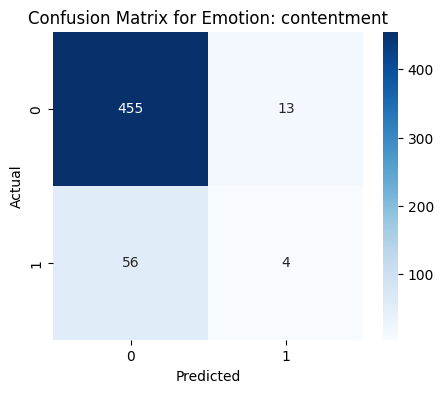

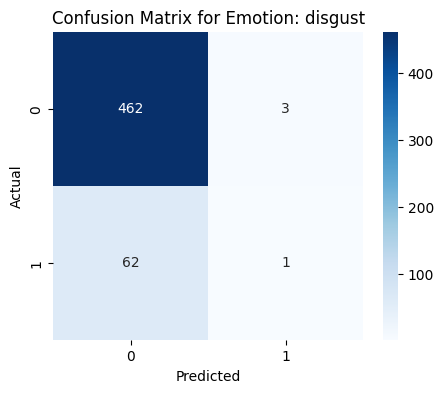

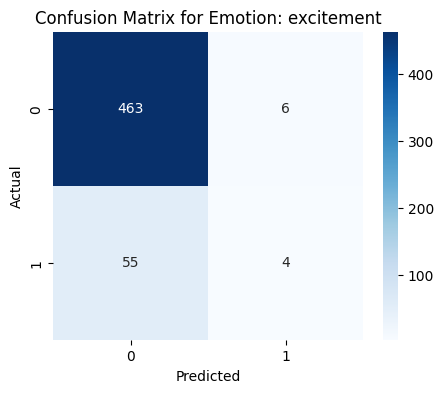

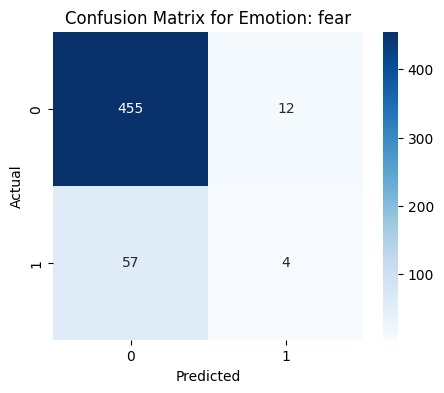

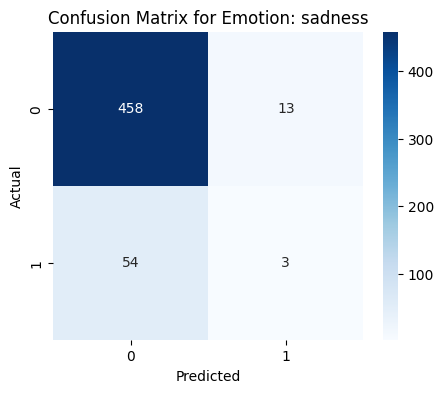

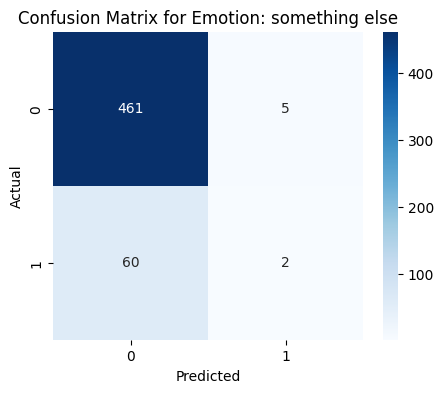

Train Set: Loss: 0.4772, Accuracy: 0.8746


In [27]:
test_loss, test_accuracy = evaluate_classification(modelResNet, criterion, test_loader)
print(f'Train Set: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')

# Definicija AlexNet modela
Ovaj deo koda definiše AlexNet model sa pretreniranjem na postojećim podacima. Pretreniran AlexNet model koristi se kao osnova, a poslednji sloj je zamenjen kako bi odgovarao broju klasa (emocija) u našem datasetu

In [28]:
def create_alexnet_model(num_classes):
    model = models.alexnet(pretrained=True)
    # Zamenjujemo poslednji sloj sa slojem za broj klasa
    model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
    
    return model

# Inicijalizacija AlexNet modela

In [29]:
num_classes = emotions_encoded.shape[1] 
alexNetModel = create_alexnet_model(num_classes).to(device)

/home/aleksandra/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aleksandra/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Definisanje kriterijuma za gubitak i optimizatora

In [30]:
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(alexNetModel.parameters(), lr=0.0001)

# Treniranje AlexNet modela

In [31]:
train_losses, train_accuracies, val_losses, val_accuracies = train_classification(
    alexNetModel, criterion, optimizer, number_of_epochs=10,
    train_loader=train_loader, validation_loader=val_loader
)

Epoch [1/10], Train Loss: 0.3802, Train Accuracy: 0.8824
Epoch [1/10], Validation Loss: 0.3520, Validation Accuracy: 0.8874
Epoch [2/10], Train Loss: 0.3414, Train Accuracy: 0.8869
Epoch [2/10], Validation Loss: 0.3490, Validation Accuracy: 0.8874
Epoch [3/10], Train Loss: 0.3258, Train Accuracy: 0.8872
Epoch [3/10], Validation Loss: 0.3588, Validation Accuracy: 0.8866
Epoch [4/10], Train Loss: 0.3053, Train Accuracy: 0.8879
Epoch [4/10], Validation Loss: 0.3648, Validation Accuracy: 0.8872
Epoch [5/10], Train Loss: 0.2796, Train Accuracy: 0.8929
Epoch [5/10], Validation Loss: 0.3784, Validation Accuracy: 0.8849
Epoch [6/10], Train Loss: 0.2452, Train Accuracy: 0.9021
Epoch [6/10], Validation Loss: 0.4065, Validation Accuracy: 0.8784
Epoch [7/10], Train Loss: 0.2005, Train Accuracy: 0.9189
Epoch [7/10], Validation Loss: 0.4114, Validation Accuracy: 0.8742
Epoch [8/10], Train Loss: 0.1594, Train Accuracy: 0.9316
Epoch [8/10], Validation Loss: 0.4563, Validation Accuracy: 0.8744
Epoch [9

# Vizualizacija gubitka i tačnosti

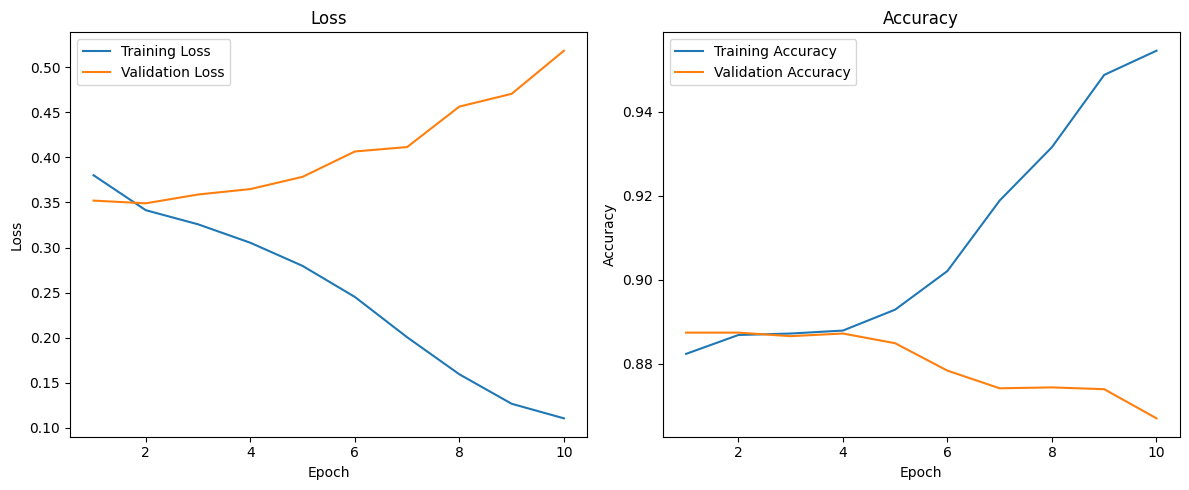

In [32]:
plot_classification(train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluacija AlexNet modela na test skupu

Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x7f0e361c0ee0>
Accuracy: 0.0549
Precision: 0.2045
Recall: 0.0604
F1 Score: 0.0884


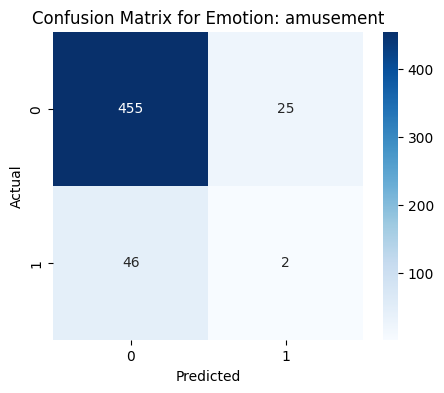

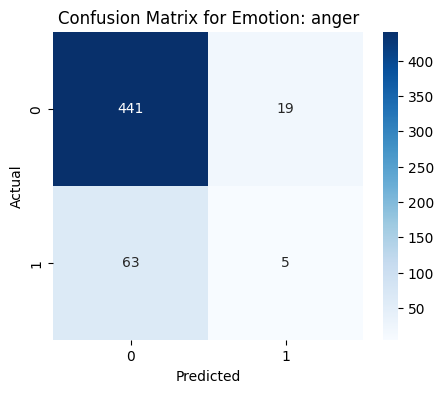

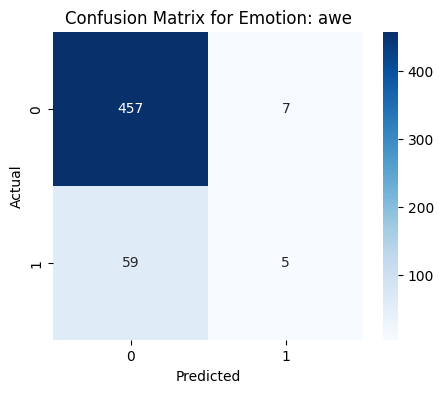

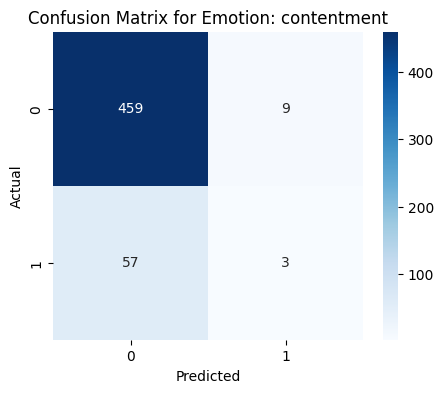

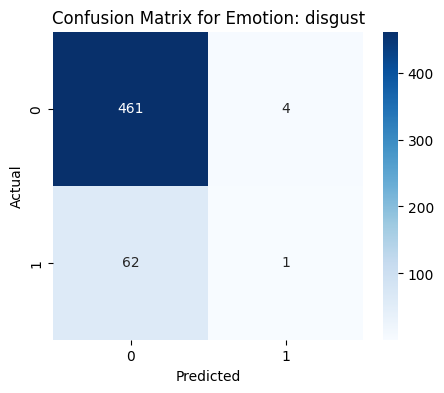

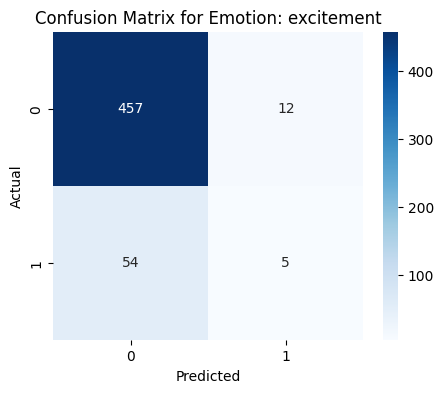

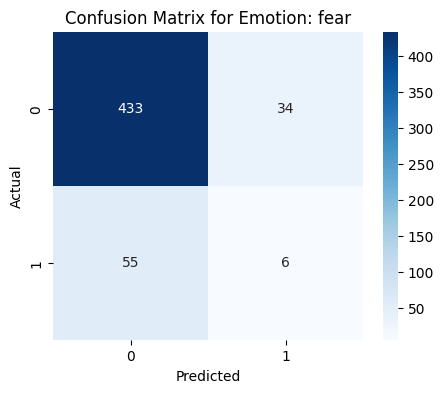

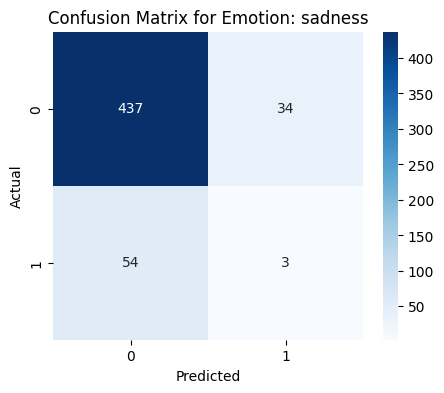

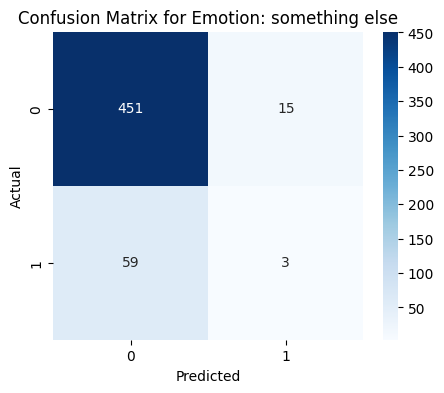

Train Set: Loss: 0.5317, Accuracy: 0.8594


In [33]:
test_loss, test_accuracy = evaluate_classification(alexNetModel, criterion, test_loader)
print(f'Train Set: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')

# Definisanje Custom CNN modela

Definisan je CustomCNN model koji koristi tri konvoluciona sloja sa MaxPool-om, a zatim dva potpuno povezana sloja za klasifikaciju slika na osnovu emocija. 

Korišćenje MaxPool sloja omogućava smanjenje dimenzija slike kroz svakodnevne transformacije dok zadržava važne karakteristike

Dodavanje Dropout sloja pomaže u regularizaciji i smanjenju prenaučenosti modela

Na kraju, slika se transformiše u vektor koji se prosleđuje kroz linearne slojeve.

In [34]:
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        
        # Definisanje slojeva
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # Prvi konvolucioni sloj
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # Drugi konvolucioni sloj
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  # Treći konvolucioni sloj
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling sloj
        
        # Fully connected slojevi
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # 128 filtera * 28*28 veličina slike posle konvolucija
        self.fc2 = nn.Linear(512, num_classes)  # Izlaz sa brojem klasa (emocija)
        
        # Dropout za regularizaciju
        self.dropout = nn.Dropout(0.7)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        # Flatten slika u vektor
        x = x.view(-1, 128 * 28 * 28)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Inicijalizacija CustomCNN modela

In [35]:
num_classes = emotions_encoded.shape[1] 
customCnnModel = CustomCNN(num_classes).to(device)

# Definisanje kriterijuma i optimizatora

In [36]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(customCnnModel.parameters(), lr=0.0001, weight_decay=1e-5)

# Treniranje CustomCNN modela

In [37]:
train_losses, train_accuracies, val_losses, val_accuracies = train_classification(
    customCnnModel, criterion, optimizer, number_of_epochs=10, 
    train_loader=train_loader, validation_loader=val_loader
)

Epoch [1/10], Train Loss: 0.4066, Train Accuracy: 0.8868
Epoch [1/10], Validation Loss: 0.3560, Validation Accuracy: 0.8874
Epoch [2/10], Train Loss: 0.3806, Train Accuracy: 0.8869
Epoch [2/10], Validation Loss: 0.3539, Validation Accuracy: 0.8874
Epoch [3/10], Train Loss: 0.3716, Train Accuracy: 0.8869
Epoch [3/10], Validation Loss: 0.3515, Validation Accuracy: 0.8874
Epoch [4/10], Train Loss: 0.3656, Train Accuracy: 0.8869
Epoch [4/10], Validation Loss: 0.3514, Validation Accuracy: 0.8874
Epoch [5/10], Train Loss: 0.3645, Train Accuracy: 0.8869
Epoch [5/10], Validation Loss: 0.3513, Validation Accuracy: 0.8874
Epoch [6/10], Train Loss: 0.3633, Train Accuracy: 0.8867
Epoch [6/10], Validation Loss: 0.3509, Validation Accuracy: 0.8874
Epoch [7/10], Train Loss: 0.3583, Train Accuracy: 0.8869
Epoch [7/10], Validation Loss: 0.3511, Validation Accuracy: 0.8874
Epoch [8/10], Train Loss: 0.3567, Train Accuracy: 0.8869
Epoch [8/10], Validation Loss: 0.3501, Validation Accuracy: 0.8874
Epoch [9

# Prikaz gubitka i tačnosti tokom epoha

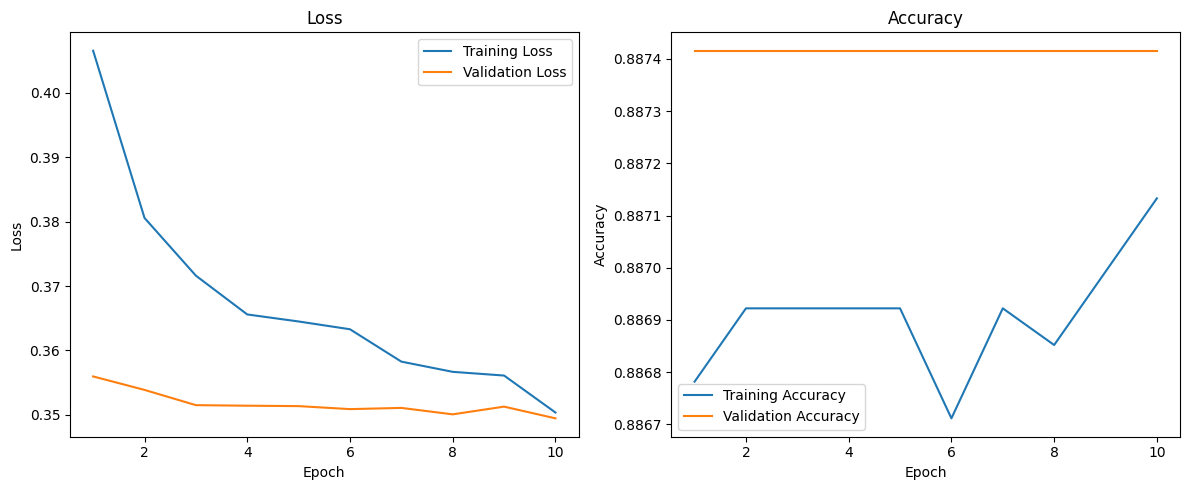

In [38]:
plot_classification(train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluacija CustomCNN modela

Model evaluation on: <torch.utils.data.dataloader.DataLoader object at 0x7f0e361c0ee0>
Accuracy: 0.0549
Precision: 0.1826
Recall: 0.0614
F1 Score: 0.0887


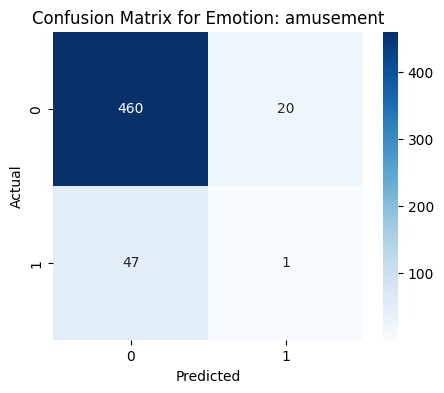

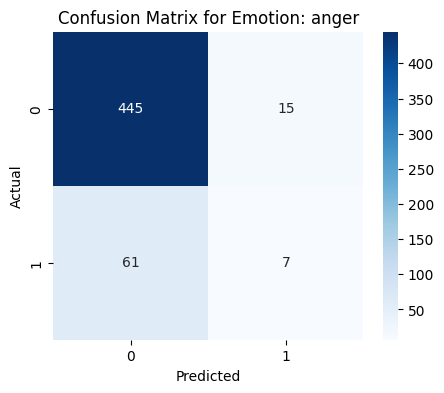

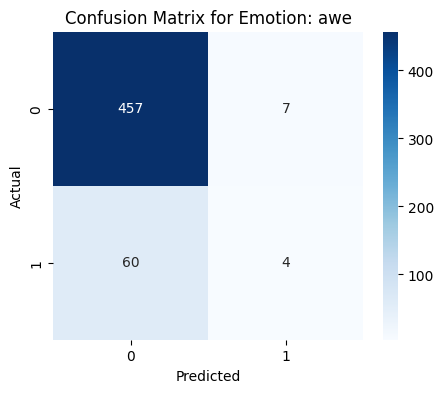

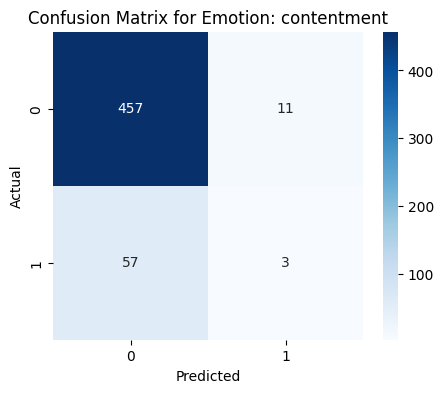

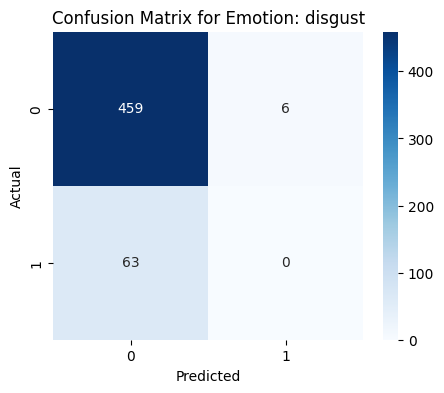

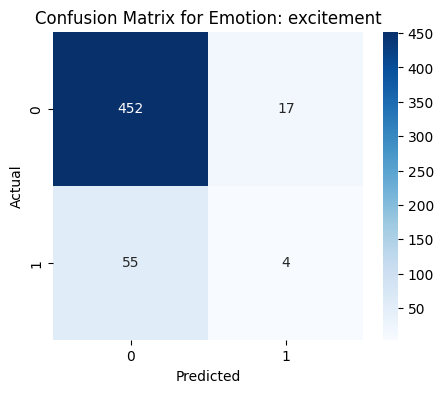

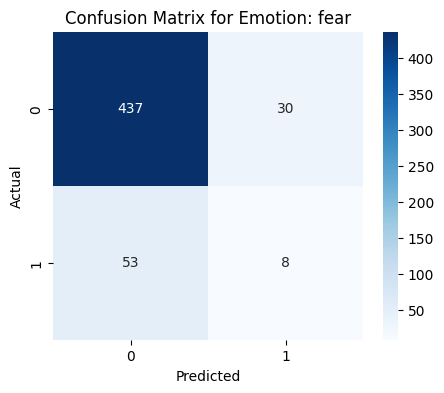

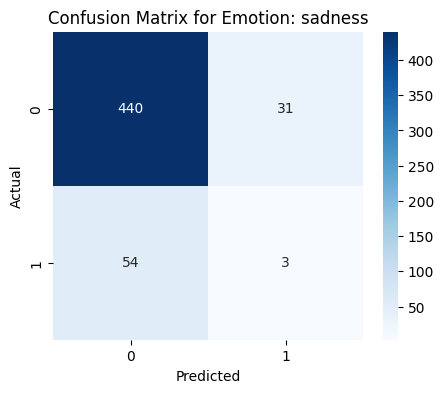

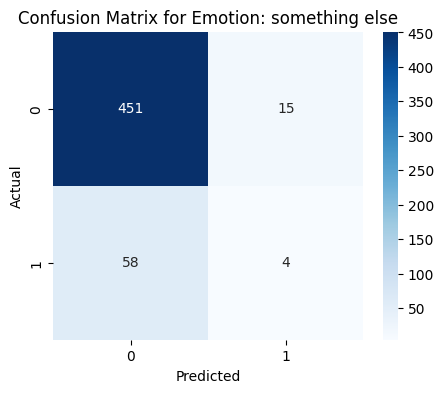

Train Set: Loss: 0.5296, Accuracy: 0.8611


In [39]:
test_loss, test_accuracy = evaluate_classification(alexNetModel, criterion, test_loader)
print(f'Train Set: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')

# Čuvanje modela

In [40]:
model_filename = 'models/modelResNet.model'

with open(model_filename, 'wb') as pickle_file:
    pickle.dump(modelResNet, pickle_file)

model_filename = 'models/alexNetModel.model'

with open(model_filename, 'wb') as pickle_file:
    pickle.dump(alexNetModel, pickle_file)

model_filename = 'models/customCnnModel.model'

with open(model_filename, 'wb') as pickle_file:
    pickle.dump(customCnnModel, pickle_file)